In [1]:
import pydotplus
import pyparsing
import pygraphviz as pgv
import networkx as nx
import json
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import dijkstra
import smacofSphere
import matplotlib.pyplot as plt
from math import cos, sin
# import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing


In [30]:
g = pydotplus.graph_from_dot_file("sample.dot")
nx_graph = nx.from_pydot(g)
Gc = max(nx.connected_component_subgraphs(nx_graph), key=len)

print(len(Gc.nodes()))

n_list = Gc.nodes()
g_mat = np.ones(shape=(len(Gc.nodes()),len(Gc.nodes())))
g_mat = 100*g_mat
print(np.shape(g_mat), np.max(g_mat),np.min(g_mat))
# Gc = max(nx.connected_component_subgraphs(dot_graph), key=len)
# gmat = nx.algorithms.shortest_paths.unweighted.all_pairs_shortest_path(Gc)
g_mat = np.ones(shape=(len(Gc.nodes()),len(Gc.nodes())))
g_mat = 100*g_mat
n_list = list(Gc.nodes())
for e in Gc.edges():
    try:
        #Graph is weighted
        g_mat[n_list.index(e[0])][n_list.index(e[1])] = float(Gc.get_edge_data(e[0],e[1])[0]['weight'])
        g_mat[n_list.index(e[1])][n_list.index(e[0])] = float(Gc.get_edge_data(e[1],e[0])[0]['weight'])
    except:
        #Graph is unweighted
        g_mat[n_list.index(e[0])][n_list.index(e[1])] = 1.0
        g_mat[n_list.index(e[1])][n_list.index(e[0])] = 1.0
g_mat = np.asarray(g_mat)
g_mat = 1.1 - g_mat/np.max(g_mat)
print(np.max(g_mat),np.min(g_mat))

4
((4, 4), 100.0, 100.0)
(1.09, 0.10000000000000009)


In [31]:

# gmat = 1.1 - (g_mat/float(np.max(g_mat)))
# print(np.max(gmat), np.min(gmat), np.mean(gmat))
g_mat = dijkstra(g_mat)
print(np.max(g_mat), np.min(g_mat), np.mean(g_mat))
# for x in g_mat:
#     print(x)
end = 1 - (g_mat/np.max(g_mat))
np.fill_diagonal(end, 0)
end = (end + end.T)/2


(1.09, 0.0, 0.6937500000000001)


In [33]:
res = smacofSphere.smacofSphere(end, itmax = 5000)


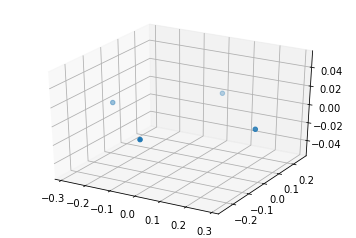

In [34]:
%matplotlib inline 


# print(np.real(res[0]))
ax = plt.axes(projection='3d')
ax.scatter(np.real(res[0][:,0]),np.real(res[0][:,1]),np.real(res[0][:,2]))


# Projections

In [35]:
def stereo(v):
#     R = np.linalg.norm([x,y,z])
    x,y,z = preprocessing.normalize(np.asarray(v).reshape(1, -1), norm='l2')[0]
    return [x/(1-z), y/(1-z)]
    
def inv_stereo(v):
    x = float(v[0])
    y = float(v[1])
    return [(2*x)/(1+x**2+y**2), (2*y)/(1+x**2+y**2), (x**2+y**2-1)/(1+x**2+y**2)]




In [36]:
def rotate_x(v,t):
    x = v[0]
    y = v[1]*cos(t) - v[2]*sin(t)
    z = v[1]*sin(t) + v[2]*cos(t)
    return (x,y,z)
def rotate_y(v,t):
    x = v[0]*cos(t) - v[2]*sin(t)
    y = v[1]
    z = v[0]*sin(t) + v[2]*cos(t)
    return (x,y,z)
def rotate_z(v,t):
    x = v[0]*cos(t) - v[1]*sin(t)
    y = v[0]*sin(t) + v[1]*cos(t)
    z = v[2]
    return(x,y,z)
def rotate(l):
    tx = np.random.uniform(low = 0, high = 2*np.pi)
    ty = np.random.uniform(low = 0, high = 2*np.pi)
    tz = np.random.uniform(low = 0, high = 2*np.pi)
    for x in range(len(l)):
        l[x] = rotate_z(rotate_y(rotate_x(l[x],tx),ty),tz)
    return l

In [37]:
coords = res[0]*100
for i in range(len(coords)):
    coords[i] = coords[i]/np.linalg.norm(coords[i])
print(np.linalg.norm(coords[0]))
coords = rotate(coords)

1.0


In [38]:
test_coords = []

for x in coords:
    test_coords.append(inv_stereo(stereo(x)))

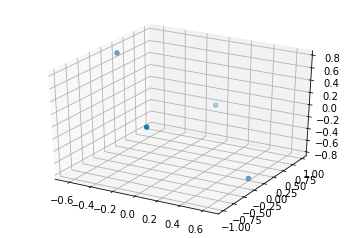

In [39]:
%matplotlib inline 

test_coords = np.asarray(test_coords)

# print(np.real(res[0]))
ax = plt.axes(projection='3d')
ax.scatter(np.real(test_coords[:,0]),np.real(test_coords[:,1]),np.real(test_coords[:,2]))


In [40]:
coords2d = np.zeros([len(coords),2])

for x in range(len(coords)):
        coords2d[x] = stereo(coords[x])
#         print(np.linalg.norm(coords2d[x]))

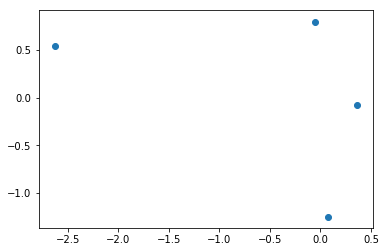

In [41]:
plt.scatter(coords2d[:,0],coords2d[:,1])

In [42]:
pos_vals = {}
h_vals = {}
w_vals = {}
id_vals = {}
for i in range(len(coords2d)):
    id_vals[Gc.nodes(data=True)[i][0]] = i
    pos_vals[Gc.nodes(data=True)[i][0]] = str(coords2d[i][0])+","+str(coords2d[i][1])
    h_vals[Gc.nodes(data=True)[i][0]] = 0.002
    w_vals[Gc.nodes(data=True)[i][0]] = 0.002
nx.set_node_attributes(Gc, values = pos_vals, name = 'pos')
nx.set_node_attributes(Gc, values = h_vals, name = 'height')
nx.set_node_attributes(Gc, values = w_vals, name = 'width')
nx.set_node_attributes(Gc, values = id_vals, name = "id")

In [43]:
print(Gc.nodes(data=True))

[('1', {'cluster': '"3"', 'pos': '0.36467535996746725,-0.07481180859162871', 'height': 0.002, 'width': 0.002, 'label': '"Visualization"', 'id': 0}), ('0', {'cluster': '"3"', 'pos': '-0.04907916464154613,0.7982347506838142', 'height': 0.002, 'width': 0.002, 'label': '"Drawing"', 'id': 1}), ('2', {'cluster': '"2"', 'pos': '-2.6314137319621764,0.5398393704730423', 'height': 0.002, 'width': 0.002, 'label': '"Graph"', 'id': 2}), ('5', {'cluster': '"1"', 'pos': '0.07673565548634456,-1.2480462386248046', 'height': 0.002, 'width': 0.002, 'label': '"Map"', 'id': 3})]


In [45]:
nx.drawing.nx_agraph.write_dot(Gc, "sample.dot")

In [20]:
#-C=[geometrickmeans|graphkmeans|geometrichierarchical|graphhierarchical|infomap|modularity]
#run: ../scottperry_gmap/gmap/external/eba/kmeans -action=clustering -C=modularity lastfm_stereo.dot > out2
#then: gvmap -e -s -4 out2 > lastfm_clustered.dot


#Try with super simple polygons 

In [46]:
f = open("sample_clustered.dot", "r")
f.readline()
l = f.readlines()
cluster_values = []
cluster = []
pt = []
type_prev = ''

ma = 0
mi = 1000

colors = []

for x in l:
    values = x.split()
    for a in values:
        if(a == '\\'):
            pass
        elif(a == 'c' or a == 'C'):
            if(type_prev == 'poly y'):
                if(len(cluster)> 0):
                    cluster_values.append(cluster)
                    cluster = []
            type_prev = 'col'
        elif(a == 'P'):
            if(type_prev == 'poly y'):
                if(len(cluster)> 0):
                    cluster_values.append(cluster)
                    cluster = []
            type_prev = 'poly1'
        elif(a == 'L'):
            type_prev = ''
        elif(type_prev == 'poly1'):
            type_prev = 'poly y'
        elif(type_prev == 'col'):
            type_prev = 'col1'
        elif(type_prev == 'col1'):
            if(a == '-#\\'):
                type_prev = 'linebreakColor'
            else:
                colors.append(a[1:])
        elif(type_prev == 'linebreakColor'):
            colors.append('#'+a)
        elif(type_prev == 'poly y'):
            if(float(a) > ma):
                ma = float(a)
            if(float(a) < mi):
                mi = float(a)
            pt.append(a)
            type_prev = 'poly x'
        elif(type_prev == "poly x"):
            if(float(a) > ma):
                ma = float(a)
            if(float(a) < mi):
                mi = float(a)
            pt.append(a)
            pt = inv_stereo(pt)
            cluster.append(pt)
            pt = []
            type_prev = 'poly y'
f.close()

In [47]:
print(ma, mi)

(1.059626, -3.060074)


In [48]:
colors = colors[::2]
colors = colors[:len(cluster_values)]
with open('colors.js', 'w') as f:
    f.write("var colors = " + str(colors))
f.close()

In [49]:
for i in range(len(cluster_values)):
    for j in range(len(cluster_values[i])):
        cluster_values[i][j] = cluster_values[i][j]/np.linalg.norm(cluster_values[i][j])

In [50]:
#Print Cluster Values
final_str = "var clusters = ["

for x in cluster_values:
    if(x < 0.00000001):
        print(x)
    final_str = final_str+'['
    for j in x:
        final_str = final_str + "[" + str(j[0]) + "," + str(j[1]) + "," + str(j[2]) + "],"
    final_str = final_str + "],\n"
final_str = final_str+"]"
with open("clusters.js","w") as f:
    f.write(final_str)
f.close()

In [51]:
#Print Edge Values
final_str = "var gEdges = ["

for x in Gc.edges():
    final_str = final_str + "{from: "+str(Gc.node[x[0]]['id'])+", to: "+str(Gc.node[x[1]]['id'])+"},"

final_str = final_str + ']'

with open("edges.js", 'w') as f:
    f.write(final_str)
    
f.close()
    
    
    

In [52]:
# Print Label and Node location Values
a = "var smacofNodes = ["

b = "var gNodes = ["

for x in range(len(test_coords)):
    if(test_coords[x][0] < 0.00000001):
        print(test_coords[x])
    if(test_coords[x][1] < 0.00000001):
        print(test_coords[x])   
    b = b + '{label: "' + str(Gc.node[Gc.nodes()[x]]['label']) + '", pos: ['+str(test_coords[x][0]) + "," + str(test_coords[x][1]) + ',' + str(test_coords[x][2])+']' + "},"
    a = a + "["+str(test_coords[x][0]) + "," + str(test_coords[x][1]) + ',' + str(test_coords[x][2])+'],'
    
a = a + ']'
b = b + ']'


with open("node_pos.js", 'w') as f:
    f.write(a)
f.close()

with open("labels.js", 'w') as f:
    f.write(b)
f.close()



[ 0.64057648 -0.13141191 -0.75656638]
[-0.0598677   0.97370193 -0.21981902]
[-0.6405767   0.13141549  0.75656557]
[ 0.0598677  -0.97370193  0.21981902]
